In [1]:
import torch
torch.cuda.empty_cache()

In [3]:
import numpy as np
matrixA = np.array([[11,  3, 10, 3], [20, 1, 0, 1]])
matrixB = np.array([[12,  1, 10], [7, 4, 0], [4, 5, 2], [5, 2, 10]])
matrixA.dot(matrixB)

array([[208,  79, 160],
       [252,  26, 210]])

In [161]:
import glob
import json
import re
import pickle
import pandas as pd
import spacy
import string
import numpy as np
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torchtext.vocab as vocab
nlp = spacy.load('en')

# Set the random seed manually for reproducibility.
torch.manual_seed(1234)

In [162]:
def save(nameFile, toSave):
    pickle_out = open(nameFile+".pickle", "wb")
    pickle.dump(toSave, pickle_out)
    pickle_out.close()

def load(nameFile):
    pickle_in = open(nameFile+".pickle", "rb")
    return pickle.load(pickle_in)

def main_iter_files():
    print('Import data')
    output_path = '/people/maurice/ownCloud/outputGentle/'
    wordsTimeds = []
    for file in sorted(glob.glob(output_path + '*')):
        print(file)
        if 'wordsTimed' in file and 'pickle' not in file:
            wordsTimed = pd.read_csv(file)  # load(file)
            print(wordsTimed.head())
            wordsTimeds.append(wordsTimed)
            # wordsTimedGby = wordsTimed.groupby('idSentence')
            '''sentenceTimed = wordsTimedGby.apply(lambda x: x.count())
            sentenceTimed[1] = sentenceTimed.astype(np.float)/len(g) 
            print sentenceTimed'''
    return wordsTimeds

In [163]:
wts = main_iter_files()

Import data
/people/maurice/ownCloud/outputGentle/align.pickle
/people/maurice/ownCloud/outputGentle/gentle_txt.pickle
/people/maurice/ownCloud/outputGentle/gentle_txtS2E23.pickle
/people/maurice/ownCloud/outputGentle/gentle_txtS2E5.pickle
/people/maurice/ownCloud/outputGentle/gntle_end.pickle
/people/maurice/ownCloud/outputGentle/gntle_endS2E23.pickle
/people/maurice/ownCloud/outputGentle/gntle_endS2E5.pickle
/people/maurice/ownCloud/outputGentle/gntle_start.pickle
/people/maurice/ownCloud/outputGentle/gntle_startS2E23.pickle
/people/maurice/ownCloud/outputGentle/gntle_startS2E5.pickle
/people/maurice/ownCloud/outputGentle/old
/people/maurice/ownCloud/outputGentle/phonesTimesS1E1.csv
/people/maurice/ownCloud/outputGentle/phonesTimesS1E10.csv
/people/maurice/ownCloud/outputGentle/phonesTimesS1E11.csv
/people/maurice/ownCloud/outputGentle/phonesTimesS1E12.csv
/people/maurice/ownCloud/outputGentle/phonesTimesS1E13.csv
/people/maurice/ownCloud/outputGentle/phonesTimesS1E14.csv
/people/mau

In [165]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [166]:
class sentenceTimed(object):
    def __init__(self, wt):
        self.reset(0)
        
    def reset(self, i):
        self.speaker = wt.iloc[i].speaker
        self.sentence_courante = ''
        if i > 0:
            self.sentence_courante += wt.iloc[i].word
        
    def modif_per_word(self, wt, i):
        self.sentence_courante += ' ' + wt.iloc[i].word

    def modif_per_sentence(self, wt, df, i):
        self.add_sentence_informations_to_dataframe(df)
        self.reset(i)
        
    def add_sentence_informations_to_dataframe(self, df):
        df.loc[len(df)] = [self.speaker, self.sentence_courante]
        # print(df)

In [167]:
# Lent
punctuation_end_sentence = ['!', '.', '?']
sentencesTimeds = []
print(len(wts))
for i, wt in enumerate(wts):
    print(i)
    sentencesTimed = pd.DataFrame(columns=['speaker', 'sentence_courante'])    

    st = sentenceTimed(wt)

    for word in range(len(wt)):
        if word == 0:
            st.modif_per_word(wt, word)
        elif wt.iloc[word].word[0].isupper() and wt.iloc[word - 1].word in punctuation_end_sentence:
            st.modif_per_sentence(wt, sentencesTimed, word)
        else:
            st.modif_per_word(wt, word)

    st.add_sentence_informations_to_dataframe(sentencesTimed)
    sentencesTimeds.append(sentencesTimed)

39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [168]:
sentencesTimeds[0]

,speaker,sentence_courante
0,Sheldon,So if a photon is directed through a plane wi...
1,Sheldon,"If it 's unobserved it will , however , if it ..."
2,Leonard,"Agreed , what 's your point ?"
3,Sheldon,"There 's no point , I just think it 's a good ..."
4,Leonard,Excuse me ?
5,Receptionist,Hang on .
6,Leonard,"One across is Aegean , eight down is Nabakov ,..."
7,Leonard,"See , Papa Doc 's capital idea , that 's Port ..."
8,Leonard,Haiti .
9,Receptionist,Can I help you ?


In [169]:
sentencesTimeds[0].iloc[1]

speaker                                                        Sheldon
sentence_courante    If it 's unobserved it will , however , if it ...
Name: 1, dtype: object

In [170]:
sentencesTimeds[0].iloc[1].speaker

'Sheldon'

In [171]:
sentencesTimeds[0].iloc[1].sentence_courante

"If it 's unobserved it will , however , if it 's observed after it 's left the plane but before it hits its target , it will not have gone through both slits ."

In [172]:
data = pd.concat(sentencesTimeds)

In [173]:
data

,speaker,sentence_courante
0,Sheldon,So if a photon is directed through a plane wi...
1,Sheldon,"If it 's unobserved it will , however , if it ..."
2,Leonard,"Agreed , what 's your point ?"
3,Sheldon,"There 's no point , I just think it 's a good ..."
4,Leonard,Excuse me ?
5,Receptionist,Hang on .
6,Leonard,"One across is Aegean , eight down is Nabakov ,..."
7,Leonard,"See , Papa Doc 's capital idea , that 's Port ..."
8,Leonard,Haiti .
9,Receptionist,Can I help you ?


In [174]:
data.speaker.values

array(['Sheldon', 'Sheldon', 'Leonard', ..., 'Computer voice', 'Penny',
       'Computer voice'], dtype=object)

In [175]:
data.sentence_courante.values

array([' So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits .',
       "If it 's unobserved it will , however , if it 's observed after it 's left the plane but before it hits its target , it will not have gone through both slits .",
       "Agreed , what 's your point ?", ...,
       'Some hiney would be nice , too .', 'Hiney ?', 'Honey .'],
      dtype=object)

In [20]:
X = [s.lower().split() for s in data.sentence_courante.values]
Y = [s.lower() for s in data.speaker.values]
newY = np.zeros(len(Y)-1)
for i in range(1, len(Y)):
    if Y[i] == Y[i-1]:
        newY[i-1] = 0
    else:
        newY[i-1] = 1
Y = Variable(torch.from_numpy(newY))

In [48]:
X = [s.lower().split() for s in data.sentence_courante.values]
Y = [s.lower() for s in data.speaker.values]

In [291]:
X = [s.lower().split() for s in data.sentence_courante.values]
Y = [s.lower() for s in data.speaker.values]
newY = []
for i in range(1, len(Y)):
    if Y[i] == Y[i-1]:
        newY.append([0])
    else:
        newY.append([1])
Y = Variable(torch.FloatTensor(newY))

In [292]:
print(X[0:2])
print(Y)
print(Y.shape)

[['so', 'if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits', '.'], ['if', 'it', "'s", 'unobserved', 'it', 'will', ',', 'however', ',', 'if', 'it', "'s", 'observed', 'after', 'it', "'s", 'left', 'the', 'plane', 'but', 'before', 'it', 'hits', 'its', 'target', ',', 'it', 'will', 'not', 'have', 'gone', 'through', 'both', 'slits', '.']]
tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
torch.Size([12701, 1])


In [293]:
#X_train, X_dt, Y_train, Y_dt = train_test_split(X, Y, test_size=0.2, shuffle=False)
print(len(X), len(Y))
def create_Y(Y):
    newY = []
    for i in range(1, len(Y)):
        if Y[i] == Y[i-1]:
            newY.append([0])
        else:
            newY.append([1])
    Y_new = Variable(torch.FloatTensor(newY))
    return Y_new

threshold_train_dev = int(len(X)*0.8)
threshold_dev_test = threshold_train_dev + int(len(X)*0.1)
X_train = X[:threshold_train_dev]
Y_train = create_Y(Y[:threshold_train_dev])
X_dev = X[threshold_train_dev:threshold_dev_test]
Y_dev = create_Y(Y[threshold_train_dev:threshold_dev_test])
X_test = X[threshold_dev_test:]
Y_test = create_Y(Y[threshold_dev_test:])
print(len(X_train), len(Y_train), len(X_dev), len(Y_dev), len(X_test), len(Y_test))

12702 12701
10161 10160 1270 1269 1271 1269


In [178]:
#embed = nn.Embedding(num_embeddings, embedding_dim)
# pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
#embed.weight.data.copy_(torch.from_numpy(pretrained_weight))

#we = vocab.GloVe(name='6B', dim=100)
we = vocab.FastText(language='en')
'''
pretrained_aliases = {
    "charngram.100d": partial(CharNGram),
    "fasttext.en.300d": partial(FastText, language="en"),
    "fasttext.simple.300d": partial(FastText, language="simple"),
    "glove.42B.300d": partial(GloVe, name="42B", dim="300"),
    "glove.840B.300d": partial(GloVe, name="840B", dim="300"),
    "glove.twitter.27B.25d": partial(GloVe, name="twitter.27B", dim="25"),
    "glove.twitter.27B.50d": partial(GloVe, name="twitter.27B", dim="50"),
    "glove.twitter.27B.100d": partial(GloVe, name="twitter.27B", dim="100"),
    "glove.twitter.27B.200d": partial(GloVe, name="twitter.27B", dim="200"),
    "glove.6B.50d": partial(GloVe, name="6B", dim="50"),
    "glove.6B.100d": partial(GloVe, name="6B", dim="100"),
    "glove.6B.200d": partial(GloVe, name="6B", dim="200"),
    "glove.6B.300d": partial(GloVe, name="6B", dim="300")
}
'''

def get_word_vector(word):
    return we.vectors[we.stoi[word]]

def closest(vec, n=2):#10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word_vector(w))) for w in we.itos]
    return sorted(all_dists, key=lambda t: t[1])[:n]

def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

# In the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word_vector(w2) - get_word_vector(w1) + get_word_vector(w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]

    print_tuples(closest_words[:n])

In [ ]:
# Lent
print(we.dim,'\n')
print_tuples(closest(get_word_vector('google')))
analogy('king', 'man', 'queen')
print(type(we.stoi),'\n')
a = 0
for k, v in we.stoi.items():
    if a < 10:
        print(k,v)
        a += 1
    else:
        break
print('iazkcnzejjqsdchj' in we.stoi)

300 



In [268]:
#print(get_word_vector('iazkcnzejjqsdchj'))
print('iazkcnzejjqsdchj' in we.stoi)

False


In [294]:
nunf = set()
for s in X:
    for w in s:#.split():
        if w not in we.stoi:
            nunf.add(w)
print(len(nunf), nunf)

392 {'r.', 'allergenics', 'c’mon', '’re', 'swrap', 'mimeaux', '2.6', 'apprec', 'remembe', 'pkshhhh', '1500s', '1979', 'mcflono', '13-year', 'l.a.', 'heteronic', 'mr.', 'phd.', '15,000', 'farminfarmian', "n't", '5027.3', '120', 'neeeeeoooooowwwww', 'googenfeil', 'b.', 'becauth', 'whatchacall', 'a.m.', 'nekhmakh', '3400', 'slurpie', '45', '40-mile', 'unravelable', 'cherrrkh', 'thwow', 'weducing', 'tootin’', 'benedryl', '211', '1487', '7', '18th', '30', '1908', 'quantii', 'brissket', 'crazy?what', 'costcos', '1956', 'bearclaws', 'eggoes', 'night.</i', '27', 'acetaline', 'yarmulkah', '15', '1175', 'finkleday', '99', 'chattee', '1150', '9', 'batcrap', '4,390', '64', 'indoorsy', 'misunder', '’s', 'underreacting', 'c.', 'tomowow', 'punchali', 'n=4', 'a.k.a', "'cos", 'carragenin', '4-a.', '12', 'cocktain', '1', 'parents’', '28', 'v.', '25th', 'pwoton', "'d", 'x10', '4.1855', 'lookin’', '22-year', 'a.', 'woboto', '4.8', 'stweet', '’ve', '17', '12th', '35', 'd’être', 'hoffstadter', '640', '16', 

In [295]:
'''weX = []
for i,s in enumerate(X):
    weX.append([])
    for w in s.split():
        if w in we.stoi:
            weX[i].append(get_word_vector(w))'''

to_del = []
for s in X:
    for w in s:
        if w not in we.stoi:
            to_del.append(w)
X = [[w for w in s if w not in to_del] for s in X]

In [296]:
print(X[0:2])

[['so', 'if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits', '.'], ['if', 'it', 'unobserved', 'it', 'will', ',', 'however', ',', 'if', 'it', 'observed', 'after', 'it', 'left', 'the', 'plane', 'but', 'before', 'it', 'hits', 'its', 'target', ',', 'it', 'will', 'not', 'have', 'gone', 'through', 'both', 'slits', '.']]


In [297]:
words_set = set()
for s in X:
    words_set = words_set.union(set(s))
print(len(words_set))

8842


In [300]:
words_set

TypeError: 'set' object is not subscriptable

In [299]:
we_idx = [we.stoi[w] for w in list(words_set)]
we_idx.append(0) #for padding we need to intialize one row of vector weights

In [68]:
# map sentences to vocab
idw = 1
vocab_X = {'<PAD>':0}
for w in list(words_set):
    vocab_X[w] = idw
    idw += 1

# fancy nested list comprehension
X_num =  [[vocab_X[word] for word in sentence] for sentence in X]

print(len(vocab_X))
print(X[0:2])

NameError: name 'words_set' is not defined

In [30]:
# get the length of each sentence
X_lengths = [len(sentence) for sentence in X_num]
print(X_lengths[0:2])

# create an empty matrix with padding tokens
padding_idx = vocab_X['<PAD>']
longest_sent = max(X_lengths)
print(longest_sent)
batch_size = len(X_num)
padded_X = np.ones((batch_size, longest_sent)) * padding_idx

# copy over the actual sequences
for i, x_len in enumerate(X_lengths):
    sequence = X_num[i]
    padded_X[i, 0:x_len] = sequence[:x_len]

# padded_X looks like:
print(padded_X[0:2][:])

[27, 32]
109
[[2869.  782. 7686. 2126.  591. 6245. 5823. 7686. 1026. 4200. 8377.  691.
  5450. 3236. 7742. 1339. 3146.  591. 4996. 3236.  898. 6747. 3094. 5823.
  7503.  691. 2943.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [ 782. 3236. 2137. 3236.  898. 7056. 6933. 7056.  782. 3236. 4996. 4470.
  3236. 1319. 5097. 1026. 8468. 5910. 3236. 7011. 7127. 5986. 7056. 3236.
   898. 6747. 8757. 5292. 5823. 7503.  691. 2943.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.   

In [26]:
inp = Variable(torch.LongTensor([[3,4,6], [1,3,5]]))
#inp = Variable(torch.LongTensor([3,4]))
print(inp)
embed(inp)

tensor([[3, 4, 6],
        [1, 3, 5]])


NameError: name 'embed' is not defined

In [27]:
list(range(5,2,-1))

[5, 4, 3]

In [55]:
#https://gist.github.com/Tushar-N/dfca335e370a2bc3bc79876e6270099e

def get_last_modulo(nb, mod):
    if nb%mod == 0:
        return nb
    else:
        return int(nb/mod) * mod

### Premier modèle, somme des embedding par phrases
taille_embedding = len(get_word_vector(X[0][0]))
taille_context = 3

idx_set_words = dict(zip(list(words_set), range(1,len(words_set)+1)))
idx_set_words['<PAD>'] = 0
padding_idx = idx_set_words['<PAD>']
vectorized_seqs = [[idx_set_words[w] for w in s]for s in X]
#vectorized_seqs = padded_X
print(vectorized_seqs[0:2])
embed = nn.Embedding(num_embeddings=len(words_set)+1, embedding_dim=taille_embedding, padding_idx=padding_idx)
embed.weight.data.copy_(we.vectors[we_idx])
embed.weight.requires_grad = False

# get the length of each seq in your batch
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))
print('length', seq_lengths)
# dump padding everywhere, and place seqs on the left.
# NOTE: you only need a tensor as big as your longest sequence
seq_tensor = Variable(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

print(seq_tensor[0:2])
print('nb sentences', len(vectorized_seqs))

# utils.rnn lets you give (B,L,D) tensors where B is the batch size, L is the maxlength, if you use batch_first=True
# Otherwise, give (L,B,D) tensors
seq_tensor = seq_tensor.transpose(0,1) # (B,L,D) -> (L,B,D)

# embed your sequences
seq_tensor = embed(seq_tensor)

# sum over L, all words per sentence
seq_tensor_sumed = torch.sum(seq_tensor, dim=0) #len(vectorized_seqs), taille_embedding
print('after sum', seq_tensor_sumed.shape)
seq_tensor_sumed = seq_tensor_sumed.view(len(vectorized_seqs), 1, taille_embedding)
#seq_tensor_sumed = seq_tensor_sumed.view(seq_tensor_sumed.shape[0], 1, taille_embedding)
#seq_tensor_sumed = seq_tensor_sumed.view(int(get_last_modulo(seq_tensor_sumed.shape[0], taille_context)/taille_context), taille_context, seq_tensor_sumed.shape[1])
print(seq_tensor_sumed.shape)
print('sum', seq_tensor_sumed)

bidirectional = False
input_size = taille_embedding
hidden_size = taille_embedding
num_layers = 3
nb_sentences = len(vectorized_seqs)
lstm_previous = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False, bidirectional=bidirectional)
lstm_future = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False, bidirectional=bidirectional)
tanh = nn.Tanh()
softmax = nn.Softmax()
#get mini-batch
for i in range(nb_sentences - (2*taille_context - 1) -1): #TODO split train/test/val
    indices_previous = torch.tensor(list(range(i,i+taille_context+1)))
    indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)))
    input_previous_features = torch.index_select(seq_tensor_sumed, 0, indices_previous)
    input_future_features = torch.index_select(seq_tensor_sumed, 0, indices_future)
    seq_tensor_output_previous, (ht_previous, ct_previous) = lstm_previous(input_previous_features)
    seq_tensor_output_future, (ht_future, ct_future) = lstm_future(input_future_features)
    target = Y[i + taille_context]
    seq_len = input_previous_features.shape[0]
    batch = input_previous_features.shape[1]
    #print(input_previous_features.shape) # 4 1 300
    num_directions = 1
    if bidirectional:
        num_directions = 2
    seq_tensor_output_sum = torch.cat((seq_tensor_output_previous.view(seq_len, batch, num_directions, hidden_size)[-1], seq_tensor_output_future.view(seq_len, batch, num_directions, hidden_size)[-1]), -1)
    print(seq_tensor_output_sum[-1].shape, seq_tensor_output_previous.shape, seq_tensor_output_previous.view(seq_len, batch, num_directions, hidden_size).shape, seq_tensor_output_previous[-1].shape, seq_tensor_output_future[-1].shape, seq_tensor_output_sum.shape, target)
    #torch.Size([1, 600]) torch.Size([4, 1, 300]) torch.Size([4, 1, 1, 300]) torch.Size([1, 300]) torch.Size([1, 300]) torch.Size([1, 1, 600]) tensor(1., dtype=torch.float64)
    #TODO Attention mechanism
    seq_tensor_output_sum = seq_tensor_output_sum.view(1,2*num_directions*taille_embedding) #2 is because we concatenate previous and future embeddings
    print(seq_tensor_output_sum.shape)
    W = torch.rand(1, num_directions)
    print(W.shape, seq_tensor_output_sum.shape, W.mm(seq_tensor_output_sum).shape)
    print(tanh(W.mm(seq_tensor_output_sum)).shape)
    u = torch.rand(1, 2*taille_embedding)
    print(softmax(u.mm(tanh(W.mm(seq_tensor_output_sum)).t())))
    break
# throw them through your LSTM (remember to give batch_first=True here if you packed with it)
#lstm = torch.nn.LSTM(input_size=seq_tensor_sumed.shape[2], hidden_size=seq_tensor_sumed.shape[2], num_layers=1, batch_first=False, bidirectional=False)
#print(lstm)
#seq_tensor_output, (ht, ct) = lstm(seq_tensor_sumed)
#print('output', seq_tensor_output)

# Or if you just want the final hidden state?
#print(ht[-1])

[[4169, 7342, 5962, 8437, 5164, 7482, 1566, 5962, 2918, 5311, 4970, 2797, 6516, 7058, 2511, 3073, 323, 5164, 8175, 7058, 870, 3717, 6986, 1566, 6629, 2797, 5992], [7342, 7058, 1437, 7058, 870, 6062, 4562, 6062, 7342, 7058, 8175, 7461, 7058, 8475, 129, 2918, 6632, 6473, 7058, 5287, 1649, 2816, 6062, 7058, 870, 3717, 5766, 8358, 1566, 6629, 2797, 5992]]
lenght tensor([27, 32,  6,  ...,  8,  2,  2])
tensor([[4169, 7342, 5962, 8437, 5164, 7482, 1566, 5962, 2918, 5311, 4970, 2797,
         6516, 7058, 2511, 3073,  323, 5164, 8175, 7058,  870, 3717, 6986, 1566,
         6629, 2797, 5992,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0, 

/people/maurice/anaconda3-5.1/envs/py3.6GPU/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [183]:
class HierarchicalBiLSTM_on_sentence_embedding(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, targset_size, num_layers = 3, bidirectional = False):
        super(HierarchicalBiLSTM_on_sentence_embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_directions = 1
        if self.bidirectional:
            self.num_directions = 2
        self.num_layers = num_layers

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_previous = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=False, bidirectional=bidirectional)
        self.lstm_future = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=False, bidirectional=bidirectional)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2*self.num_directions*hidden_dim, targset_size)#2 because we concatenate the both output of the lstm
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, 1, self.hidden_dim),
                torch.zeros(self.num_layers, 1, self.hidden_dim))

    def forward(self, input_previous_sentences, input_future_sentences):
        seq_tensor_output_previous, self.hidden = self.lstm_previous(input_previous_sentences, self.hidden)
        seq_tensor_output_future, self.hidden = self.lstm_future(input_future_sentences, self.hidden)
        return seq_tensor_output_previous, seq_tensor_output_future
        
        seq_len = input_previous_sentences.shape[0]
        batch = input_previous_sentences.shape[1]

        seq_tensor_output_sum = torch.cat((seq_tensor_output_previous.view(seq_len, batch, self.num_directions, self.hidden_dim)[-1,:,:], seq_tensor_output_future.view(seq_len, batch, self.num_directions, self.hidden_dim)[-1,:,:]), -1)
        #TODO Attention mechanism
        seq_tensor_output_sum = seq_tensor_output_sum.view(batch,2*self.num_directions*self.hidden_dim) #2 is because we concatenate previous and future embeddings

        #lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(seq_tensor_output_sum)
        tag_space = tag_space[0]
        prediction = torch.sigmoid(tag_space)
        return prediction

In [184]:
#https://gist.github.com/Tushar-N/dfca335e370a2bc3bc79876e6270099e

import torch.optim as optim

### Premier modèle, somme des embedding par phrases
taille_embedding = len(get_word_vector(X[0][0]))
taille_context = 3
bidirectional = False
num_layers = 3
nb_epoch = 5
targset_size = 1

idx_set_words = dict(zip(list(words_set), range(1,len(words_set)+1)))
idx_set_words['<PAD>'] = 0
padding_idx = idx_set_words['<PAD>']
vectorized_seqs = [[idx_set_words[w] for w in s]for s in X]
#vectorized_seqs = padded_X
print(vectorized_seqs[0:2])
we_idx = [0] #for padding we need to intialize one row of vector weights
we_idx += [we.stoi[w] for w in list(words_set)]
embed = nn.Embedding(num_embeddings=len(words_set)+1, embedding_dim=taille_embedding, padding_idx=padding_idx)
embed.weight.data.copy_(we.vectors[we_idx])
embed.weight.requires_grad = False

# get the length of each seq in your batch
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))
print('length', seq_lengths)
# dump padding everywhere, and place seqs on the left.
# NOTE: you only need a tensor as big as your longest sequence
seq_tensor = Variable(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

print(seq_tensor[0:2])
print('nb sentences', len(vectorized_seqs))

# utils.rnn lets you give (B,L,D) tensors where B is the batch size, L is the maxlength, if you use batch_first=True
# Otherwise, give (L,B,D) tensors
seq_tensor = seq_tensor.transpose(0,1) # (B,L,D) -> (L,B,D)

print('size seq_tensor before', seq_tensor.shape)
# embed your sequences
seq_tensor = embed(seq_tensor)
print('size seq_tensor embed', seq_tensor.shape)

# sum over L, all words per sentence
seq_tensor_sumed = torch.sum(seq_tensor, dim=0) #len(vectorized_seqs), taille_embedding
print('after sum', seq_tensor_sumed.shape)
seq_tensor_sumed = seq_tensor_sumed.view(len(vectorized_seqs), 1, taille_embedding)
#seq_tensor_sumed = seq_tensor_sumed.view(seq_tensor_sumed.shape[0], 1, taille_embedding)
#seq_tensor_sumed = seq_tensor_sumed.view(int(get_last_modulo(seq_tensor_sumed.shape[0], taille_context)/taille_context), taille_context, seq_tensor_sumed.shape[1])
print(seq_tensor_sumed.shape)
print('sum', seq_tensor_sumed)

bidirectional = False
input_size = taille_embedding
hidden_size = taille_embedding
num_layers = 3
nb_sentences = len(vectorized_seqs)

model = HierarchicalBiLSTM_on_sentence_embedding(taille_embedding, taille_embedding, targset_size, num_layers, bidirectional)
loss_function = nn.BCELoss()#NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

print('début train')
for epoch in range(nb_epoch):
    #get mini-batch
    #Data loader
    for i in range(nb_sentences - (2*taille_context + 1)): #TODO split train/test/val
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        indices_previous = torch.tensor(list(range(i,i+taille_context+1)))
        indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)))
        input_previous_features = torch.index_select(seq_tensor_sumed, 0, indices_previous)
        input_future_features = torch.index_select(seq_tensor_sumed, 0, indices_future)
        
        # Step 3. Run our forward pass.
        #prediction = model(input_previous_features, input_future_features)
        seq_tensor_output_previous, seq_tensor_output_future = model(input_previous_features, input_future_features)
        print('ok')
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(prediction, Y[i+taille_context]) #targets)
        loss.backward()
        optimizer.step()
        
        #break
    #break
print('fin train')
# See what the scores are after training
with torch.no_grad():
    i = 0
    indices_previous = torch.tensor(list(range(i,i+taille_context+1)))
    indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)))
    input_previous_features = torch.index_select(seq_tensor_sumed, 0, indices_previous)
    input_future_features = torch.index_select(seq_tensor_sumed, 0, indices_future)
    prediction = model(input_previous_features, input_future_features)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(prediction, Y[i+taille_context])

[[922, 4529, 7507, 8269, 5367, 2279, 6276, 7507, 3716, 7294, 2695, 1481, 1339, 8092, 1452, 6333, 7988, 5367, 1563, 8092, 3788, 7709, 3076, 6276, 1788, 1481, 861], [4529, 8092, 3173, 8092, 3788, 4260, 3630, 4260, 4529, 8092, 1563, 4360, 8092, 1857, 4986, 3716, 2342, 2757, 8092, 4039, 3846, 5809, 4260, 8092, 3788, 7709, 2758, 4936, 6276, 1788, 1481, 861]]
length tensor([27, 32,  6,  ...,  8,  2,  2])
tensor([[ 922, 4529, 7507, 8269, 5367, 2279, 6276, 7507, 3716, 7294, 2695, 1481,
         1339, 8092, 1452, 6333, 7988, 5367, 1563, 8092, 3788, 7709, 3076, 6276,
         1788, 1481,  861,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [34]:
with torch.no_grad():
    i = 0
    indices_previous = torch.tensor(list(range(i,i+taille_context+1)))
    indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)))
    input_previous_features = torch.index_select(seq_tensor_sumed, 0, indices_previous)
    input_future_features = torch.index_select(seq_tensor_sumed, 0, indices_future)
    prediction = model(input_previous_features, input_future_features)
    print(prediction, Y[i+taille_context])

tensor([0.6674]) tensor([1.])


In [279]:
X[0][:3]

['So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.',
 "If it's unobserved it will, however, if it's observed after it's left the plane but before it hits its target, it will not have gone through both slits.",
 "Agreed, what's your point?"]

In [302]:
set(X[0][:3])

{'a', 'if', 'so'}

In [310]:
v = torch.Tensor([[[1,2,3,4],[5,6,7,8],[9,10,11,12]],[[13,14,15,16],[17,18,19,20],[21,22,23,24]]]) #(1,2,3,4)
v = v.unsqueeze(0)
print(v.view(1,-1,4).shape[-1])
print(v)
print(v.view(1,-1,4))

4
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.]],

         [[13., 14., 15., 16.],
          [17., 18., 19., 20.],
          [21., 22., 23., 24.]]]])
tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])


In [314]:
print(torch.randperm(v.size()[3]))

tensor([0, 3, 1, 2])


In [334]:
m=torch.Tensor([[1,2],[4,5]])
m.shape

torch.Size([2, 2])

In [336]:
m[0,:]

tensor([1., 2.])

In [123]:
seq_tensor.shape

torch.Size([109, 12702, 300])

In [136]:
#indices_previous = torch.tensor(list(range(i,i+taille_context+1)))
#indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)))
print(indices_previous, indices_future, torch.tensor(list(range(i,i+2*taille_context+2))))

tensor([40, 41, 42, 43]) tensor([47, 46, 45, 44]) tensor([40, 41, 42, 43, 44, 45, 46, 47])


In [137]:
sentences_emb = torch.index_select(seq_tensor, 1, torch.tensor(list(range(i,i+2*taille_context+2))))
sentences_emb.shape

torch.Size([109, 8, 300])

In [138]:
rnn = nn.LSTM(sentences_emb.shape[2], sentences_emb.shape[2], num_layers=3)
h0 = torch.randn(3, sentences_emb.shape[1], sentences_emb.shape[2])
c0 = torch.randn(3, sentences_emb.shape[1], sentences_emb.shape[2])
output, (hn, cn) = rnn(sentences_emb, (h0, c0))
output.shape

torch.Size([109, 8, 300])

In [139]:
output[-1,:,:].unsqueeze(1).shape

torch.Size([8, 1, 300])

In [148]:
output[-1,:,:].unsqueeze(1)[int(sentences_emb.shape[1]/2):,:,:].shape

torch.Size([4, 1, 300])

In [116]:
seq_tensor_sumed.shape

torch.Size([12702, 1, 300])

In [110]:
input_previous_features.shape

torch.Size([4, 1, 300])

In [199]:
print(seq_tensor_output_previous.shape, seq_tensor_output_future.shape)
similarity = torch.cat((seq_tensor_output_previous[-1,:,:], seq_tensor_output_future[0,:,:]), 1)
print(similarity.shape)
attn = nn.Linear(similarity.shape[1],10)
tanh = nn.Tanh()
similarity_ = tanh(attn(similarity)).transpose(0,1)
print(similarity_.shape)
#seq_tensor_output_previous[-1,:,:].matmul(seq_tensor_output_future[0,:,:])
#alpha = nn.Linear(similarity_,1)
u = torch.empty(1, similarity_.shape[0]).uniform_(0, 1)
alpha = u.matmul(similarity_)
print(alpha.shape)
print(alpha)

torch.Size([4, 1, 300]) torch.Size([4, 1, 300])
torch.Size([1, 600])
torch.Size([10, 1])
torch.Size([1, 1])
tensor([[-0.0233]], grad_fn=<MmBackward>)


In [198]:
seq_tensor_output_previous[-1,:,:].repeat(seq_tensor_output_future.shape[0],1,1)

tensor([[[ 0.0540,  0.0462,  0.0029,  ...,  0.0238,  0.0034,  0.0120]],

        [[ 0.0540,  0.0462,  0.0029,  ...,  0.0238,  0.0034,  0.0120]],

        [[ 0.0540,  0.0462,  0.0029,  ...,  0.0238,  0.0034,  0.0120]],

        [[ 0.0540,  0.0462,  0.0029,  ...,  0.0238,  0.0034,  0.0120]]],
       grad_fn=<RepeatBackward>)

In [348]:
print(seq_tensor_output_previous.shape, seq_tensor_output_future.shape)
similarity = torch.cat((seq_tensor_output_previous[-1,:,:].repeat(seq_tensor_output_future.shape[0],1,1), seq_tensor_output_future[:,:,:]), 2)
print(similarity.shape)
attn = nn.Linear(similarity.shape[2],10)
tanh = nn.Tanh()
similarity_ = tanh(attn(similarity))
print(similarity_.shape)
#seq_tensor_output_previous[-1,:,:].matmul(seq_tensor_output_future[0,:,:])
alpha = nn.Linear(similarity_.shape[2],1)
alpha_ = alpha(similarity_)
print(alpha_.shape)
print(alpha_)
softmax = nn.Softmax(dim=0)
alpha_ = softmax(alpha_).transpose(0,1).transpose(1,2)#.unsqueeze(0)
print(alpha_.shape)
print(alpha_)
print(seq_tensor_output_future.transpose(0,1).shape)
m_p = torch.matmul(alpha_, seq_tensor_output_future.transpose(0,1)).transpose(0,1) #(32,1,4) * (32,4,4096)
print(m_p.shape)
print(m_p)

torch.Size([4, 1, 300]) torch.Size([4, 1, 300])
torch.Size([4, 1, 600])
torch.Size([4, 1, 10])
torch.Size([4, 1, 1])
tensor([[[0.1699]],

        [[0.1685]],

        [[0.1687]],

        [[0.1693]]], grad_fn=<ThAddBackward>)
torch.Size([1, 1, 4])
tensor([[[0.2502, 0.2499, 0.2499, 0.2501]]], grad_fn=<TransposeBackward0>)
torch.Size([1, 4, 300])
torch.Size([1, 1, 300])
tensor([[[ 0.0262,  0.0044, -0.0322, -0.0046,  0.0071,  0.0323, -0.0168,
           0.0076,  0.0247, -0.0462, -0.0135, -0.0454, -0.0468, -0.0304,
           0.0196, -0.0172, -0.0252,  0.0043, -0.0297, -0.0191,  0.0021,
          -0.0182,  0.0505,  0.0280, -0.0208, -0.0050, -0.0235, -0.0276,
          -0.0181,  0.0103, -0.0447, -0.0253,  0.0337, -0.0136, -0.0326,
           0.0333,  0.0374, -0.0353,  0.0186, -0.0264,  0.0330,  0.0021,
          -0.0179, -0.0116,  0.0098, -0.0015,  0.0123, -0.0356,  0.0067,
           0.0599, -0.0083, -0.0187, -0.0078,  0.0005, -0.0059, -0.0521,
           0.0194,  0.0005,  0.0225, -0.0084,

In [228]:
seq_tensor_output_sum = torch.cat((seq_tensor_output_previous[-1,:,:], seq_tensor_output_future[-1,:,:], m_p, m_p), -1)
print(seq_tensor_output_sum.shape)

torch.Size([1, 1200])


NameError: name 'batch' is not defined

In [223]:
tensor1 = torch.ones(10, 3, 4)
tensor2 = torch.randn(4)
print(tensor2)
torch.matmul(tensor1, tensor2)#.size()

tensor([ 1.4335, -1.0794,  0.0333,  2.1552])


tensor([[2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426],
        [2.5426, 2.5426, 2.5426]])

In [269]:
import csv
import glob

punctuations_end_sentence = ['.', '?', '!']

X = []
Y = []
for f in sorted(glob.glob('/vol/work2/galmant/transcripts/*')):
    with open(f, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        X_ = []
        Y_ = []
        for row in reader:
            #print(row[1], ' '.join(row[2:]))
            #print(row[2:])
            sentence = row[2]
            old_word = row[2]
            for word in row[3:]:
                #print(word, sentence, old_word)
                #print(word, any(punctuation in old_word for punctuation in punctuations_end_sentence), word[0].isupper())
                if any(punctuation in old_word for punctuation in punctuations_end_sentence) and word and word[0].isupper():
                    X_.append(sentence)
                    Y_.append(row[1])
                    sentence = word
                else:
                    sentence += ' '+word
                old_word = word
            X_.append(sentence)
            Y_.append(row[1])
        X.append(X_)
        Y.append(Y_)
    break
print(X[0])
print(Y[0])

['So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.', "If it's unobserved it will, however, if it's observed after it's left the plane but before it hits its target, it will not have gone through both slits.", "Agreed, what's your point?", "There's no point, I just think it's a good idea for a tee-shirt. ", 'Excuse me?', 'Hang on. ', 'One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is... move your finger... phylum, which makes fourteen across Port-au-Prince.', "See, Papa Doc's capital idea, that's Port-au-Prince.", 'Haiti. ', 'Can I help you?', 'Yes.', 'Um, is this the High IQ sperm bank?', "If you have to ask, maybe you shouldn't be here.", 'I think this is the place.', 'Fill these out.', 'Thank-you.', "We'll be right back.", 'Oh, take your time.', "I'll just finish my crossword puzzle.", 'Oh wait.', "Leonard, I don't think I can do this.", 'What, are you kidding?', "You'r

In [242]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [273]:
for x,y in zip(X,Y):
    print(x,y)

['So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.', "If it's unobserved it will, however, if it's observed after it's left the plane but before it hits its target, it will not have gone through both slits.", "Agreed, what's your point?", "There's no point, I just think it's a good idea for a tee-shirt. ", 'Excuse me?', 'Hang on. ', 'One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is... move your finger... phylum, which makes fourteen across Port-au-Prince.', "See, Papa Doc's capital idea, that's Port-au-Prince.", 'Haiti. ', 'Can I help you?', 'Yes.', 'Um, is this the High IQ sperm bank?', "If you have to ask, maybe you shouldn't be here.", 'I think this is the place.', 'Fill these out.', 'Thank-you.', "We'll be right back.", 'Oh, take your time.', "I'll just finish my crossword puzzle.", 'Oh wait.', "Leonard, I don't think I can do this.", 'What, are you kidding?', "You'r

In [28]:
print(torch.__version__)
embed = nn.Embedding(len(words_set), len(get_word_vector(X[0][0])))
embed.weight.data.copy_(we.vectors[we_idx])
embed.weight.requires_grad = False

idx_set_words = dict(zip(list(words_set), range(len(words_set))))

vectorized_seqs = [[idx_set_words[w] for w in s]for s in X]
print(vectorized_seqs[0:2])

# get the length of each seq in your batch
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))
print(seq_lengths)
# dump padding everywhere, and place seqs on the left.
# NOTE: you only need a tensor as big as your longest sequence
seq_tensor = Variable(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

# SORT YOUR TENSORS BY LENGTH!
seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]

# utils.rnn lets you give (B,L,D) tensors where B is the batch size, L is the maxlength, if you use batch_first=True
# Otherwise, give (L,B,D) tensors
seq_tensor = seq_tensor.transpose(0,1) # (B,L,D) -> (L,B,D)
print(seq_tensor)

# embed your sequences
seq_tensor = embed(seq_tensor)
print(seq_tensor)

# pack them up nicely
packed_input = pack_padded_sequence(seq_tensor, seq_lengths.cpu().numpy())
print(packed_input)

# throw them through your LSTM (remember to give batch_first=True here if you packed with it)
packed_output, (ht, ct) = lstm(packed_input)
print(packed_output)

# unpack your output if required
output, _ = pad_packed_sequence(packed_output)
print(output)

# Or if you just want the final hidden state?
print(ht[-1])

0.4.0
[[6597, 3994, 6329, 2163, 7702, 5246, 8520, 6329, 149, 3939, 818, 4668, 6880, 1140, 8191, 4768, 4629, 7702, 5182, 1140, 3685, 8087, 837, 8520, 1533, 4668, 8367], [3994, 1140, 7151, 1140, 3685, 3336, 7496, 3336, 3994, 1140, 5182, 6006, 1140, 6507, 934, 149, 773, 8034, 1140, 1426, 3684, 3737, 3336, 1140, 3685, 8087, 6252, 702, 8520, 1533, 4668, 8367]]
tensor([  27,   32,    6,  ...,    8,    2,    2])
tensor([[  934,  2177,  2526,  ...,  1903,  8367,  8367],
        [ 6089,  2812,  3336,  ...,     0,     0,     0],
        [ 5781,  5567,  2177,  ...,     0,     0,     0],
        ...,
        [ 5853,     0,     0,  ...,     0,     0,     0],
        [ 2167,     0,     0,  ...,     0,     0,     0],
        [ 6124,     0,     0,  ...,     0,     0,     0]])
tensor([[[-6.5334e-02, -9.3031e-02, -1.7571e-02,  ...,  1.6642e-01,
          -1.3079e-01,  3.5397e-02],
         [-4.0083e-01,  1.3992e-01,  1.2907e-01,  ...,  2.3206e-01,
           7.9414e-02,  1.3813e-01],
         [-3.6183e-

NameError: name 'lstm' is not defined

In [29]:
def flatten(l):
    return list(itertools.chain.from_iterable(l))

seqs = ['ghatmasala','nicela','c-pakodas']

# make <pad> idx 0
vocab = ['<pad>'] + sorted(list(set(flatten(seqs))))
print(vocab)

vectorized_seqs = [[vocab.index(tok) for tok in seq]for seq in seqs]

# get the length of each seq in your batch
seq_lengths = map(len, vectorized_seqs)
print(list(seq_lengths))

['<pad>', '-', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 's', 't']
[10, 6, 9]


In [30]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [3]:
#https://www.kdnuggets.com/2018/06/taming-lstms-variable-sized-mini-batches-pytorch.html
#https://github.com/EdGENetworks/attention-networks-for-classification/blob/master/model.py
#https://github.com/EdGENetworks/attention-networks-for-classification/blob/master/attention_model_validation_experiments.ipynb
#https://explosion.ai/blog/deep-learning-formula-nlp
#https://github.com/koustuvsinha/hred-py/blob/master/hred_pytorch.py

In [4]:
import os

os.chdir('HierarchicalRNN/')
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: 'HierarchicalRNN/'

In [9]:
import data as dt
import model as md
import pickle
import numpy as np
import torch

In [10]:
import glob
import json
import re
import pickle
import pandas as pd
import spacy
import string
import numpy as np
import itertools
import csv
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split

import torchtext.vocab as vocab
nlp = spacy.load('en')

def save(nameFile, toSave):
    pickle_out = open(nameFile+".pickle", "wb")
    pickle.dump(toSave, pickle_out)
    pickle_out.close()

def load(nameFile):
    pickle_in = open(nameFile+".pickle", "rb")
    return pickle.load(pickle_in)

def get_word_vector(word):
    return we.vectors[we.stoi[word]]

def closest(vec, n=2):#10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word_vector(w))) for w in we.itos]
    return sorted(all_dists, key=lambda t: t[1])[:n]

def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

# In the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word_vector(w2) - get_word_vector(w1) + get_word_vector(w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]

    print_tuples(closest_words[:n])

def load_data(path_transcripts='/vol/work2/galmant/transcripts/', type_sentence_embedding='lstm'):
    punctuations_end_sentence = ['.', '?', '!']

    we = None
    if type_sentence_embedding == 'lstm':
        we = vocab.FastText(language='en')
        '''
        pretrained_aliases = {
            "charngram.100d": partial(CharNGram),
            "fasttext.en.300d": partial(FastText, language="en"),
            "fasttext.simple.300d": partial(FastText, language="simple"),
            "glove.42B.300d": partial(GloVe, name="42B", dim="300"),
            "glove.840B.300d": partial(GloVe, name="840B", dim="300"),
            "glove.twitter.27B.25d": partial(GloVe, name="twitter.27B", dim="25"),
            "glove.twitter.27B.50d": partial(GloVe, name="twitter.27B", dim="50"),
            "glove.twitter.27B.100d": partial(GloVe, name="twitter.27B", dim="100"),
            "glove.twitter.27B.200d": partial(GloVe, name="twitter.27B", dim="200"),
            "glove.6B.50d": partial(GloVe, name="6B", dim="50"),
            "glove.6B.100d": partial(GloVe, name="6B", dim="100"),
            "glove.6B.200d": partial(GloVe, name="6B", dim="200"),
            "glove.6B.300d": partial(GloVe, name="6B", dim="300")
        }
        '''

    X_all = []
    Y_all = []
    words_set = set()
    for f in sorted(glob.glob(path_transcripts+'*')):
        with open(f, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            X_ = []
            Y_ = []
            for row in reader:
                sentence = row[2]
                old_word = row[2]
                for word in row[3:]:
                    if any(punctuation in old_word for punctuation in punctuations_end_sentence) and word and word[0].isupper():
                        X_.append(sentence)
                        Y_.append(row[1])
                        sentence = word
                    else:
                        sentence += ' '+word
                    old_word = word
                if sentence and row[1]:
                    X_.append(sentence)
                    Y_.append(row[1])
            Y = [s.lower() for s in Y_]
            if type_sentence_embedding == 'lstm':
                X = [s.lower().split() for s in X_]
                #Y = [s.lower() for s in Y_]
                to_del = []
                for s in X:
                    for w in s:
                        if w not in we.stoi:
                            to_del.append(w)
                X = [[w for w in s if w not in to_del] for s in X]
                for words_per_sentence in X:
                    words_set = words_set.union(set(words_per_sentence))
            else:
                X = X_
                Y = Y_
            if len(X)>0 and len(Y)>0:
                X_all.append(X)
                Y_all.append(Y)
            assert len(X) == len(Y)

    threshold_train_dev = int(len(X_all)*0.8)
    threshold_dev_test = threshold_train_dev + int(len(X_all)*0.1)
    X_train = X_all[:threshold_train_dev]
    Y_train = Y_all[:threshold_train_dev]
    X_dev = X_all[threshold_train_dev:threshold_dev_test]
    Y_dev = Y_all[threshold_train_dev:threshold_dev_test]
    X_test = X_all[threshold_dev_test:]
    Y_test = Y_all[threshold_dev_test:]
    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test, words_set, we

In [11]:
device = 'cuda:0'
is_trained = False
type_sentence_embedding='infersent'

X_train, Y_train, X_dev, Y_dev, X_test, Y_test, words_set, we = load_data(type_sentence_embedding=type_sentence_embedding)
hidden_size = 300
batch_size=32
if type_sentence_embedding == 'lstm':
    taille_embedding = len(we.vectors[we.stoi[X_train[0][0][0]]])
else:
    taille_embedding = 4096

In [12]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torchtext.vocab as vocab
import numpy as np
import matplotlib.pyplot as plt
import nltk
import math
import itertools
from random import shuffle
from models import InferSent

# Set the random seed manually for reproducibility.
torch.manual_seed(1234)

V = 2
MODEL_PATH = '/vol/work3/maurice/encoder/infersent%s.pickle' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
W2V_PATH = '/vol/work3/maurice/dataset/fastText/crawl-300d-2M-subword.vec'
infersent.set_w2v_path(W2V_PATH)

In [13]:
from random import sample

def split_by_context(X, Y, taille_context, batch_size, device='cpu'): #(8..,1,4096)
    list_tensors_X = []
    list_tensors_Y = []
    for i in range(X.shape[0] - (2*taille_context + 1)): #NOT 1 NOW 0 FOR THE NUMBER OF SENTENCES
        list_tensors_X.append(torch.index_select(X, 0, torch.tensor(list(range(i,i+2*(taille_context+1))), device=device))) #(8,1,4096)
        list_tensors_Y.append(torch.index_select(Y, 0, torch.tensor([taille_context], device=device))) #(1)
    tensor_split_X = torch.stack(list_tensors_X).transpose(0,1).view(2*(taille_context+1),-1,X.shape[-1]) #(n-8,8,1,4096) -> (8,n,1,4096) -> (8,n,4096)
    tensor_split_Y = torch.stack(list_tensors_Y).view(1,-1)#.squeeze(0) #.transpose(0,1) #(n,1) -> (1,n)
    minis_batch_X = {}
    minis_batch_Y = {}
    nb_batches = int(tensor_split_X.shape[1]/batch_size)
    for i in range(nb_batches):
        minis_batch_X[i] = tensor_split_X[:,i*batch_size:(i+1)*batch_size,:]
        minis_batch_Y[i] = tensor_split_Y[:,i*batch_size:(i+1)*batch_size]
    minis_batch_X[nb_batches] = tensor_split_X[:,nb_batches*batch_size:,:] #n/32 tensors of (8,32,4096)
    minis_batch_Y[nb_batches] = tensor_split_Y[:,nb_batches*batch_size:] #n/32 tensors of (1,32)
    shuffle_ids = sample(list(range(nb_batches+1)), k=nb_batches+1)
    return [minis_batch_X[i] for i in shuffle_ids], [minis_batch_Y[i] for i in shuffle_ids]

In [14]:
X_all=X_train
Y_all=Y_train
taille_context=3
bidirectional=False
num_layers=1
nb_epoch=5
targset_size=1
idx_set_words = None
embed = None
dim = 0

model = md.HierarchicalBiLSTM_on_sentence_embedding(taille_embedding, hidden_size, targset_size, num_layers, bidirectional=bidirectional, device=device, type_sentence_embedding=type_sentence_embedding)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=None)#pos_weight)#BCELoss()#NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
#scheduler = StepLR(optimizer, step_size=math.ceil(nb_epoch/5), gamma=0.2)

# Concatenate all the datas in pytorch lists of tensors and create the mini-batch (8,32,4096) or (109,8*32,300)
season_episode = 0
poucentages_majority_class = []
inputs_embeddings = []
outputs_refs = []
for X_,Y_ in zip(X_all,Y_all):
    if season_episode == 2:
        break
    print('file',season_episode,'on',len(X_all))
    infersent.build_vocab(X_, tokenize=True)
    words_embeddings = infersent.encode(X_, tokenize=True) #In fact it's sentences embeddings, just to have the same name !!! (B,D)
    words_embeddings = torch.from_numpy(words_embeddings).unsqueeze(1)# (B,D) -> (L,B,D)
    words_embeddings = words_embeddings.to(device)
    #words_embeddings : (8..,1,4096) or (109,8..,300); 8.. -> number of sentences, 8 -> context size, 109 -> max number of words per sentence, 300 or 4096 -> embeddings size
    Y, poucentage_majority_class = md.create_Y(Y_, device) #(8..)
    #TODO CURRENTLY ONLY FOR INFERSENT
    inputs_embeddings_, outputs_refs_ = split_by_context(words_embeddings, Y, taille_context, batch_size, device=device) #(n/32,8,32,4096) and (n/32,1,32)
    inputs_embeddings += inputs_embeddings_
    outputs_refs += outputs_refs_
    poucentages_majority_class.append(poucentage_majority_class)
    season_episode += 1
print('mean poucentages majority class', sum(poucentages_majority_class)/len(poucentages_majority_class))

file 0 on 176
Found 927(/934) words with w2v vectors
Vocab size : 927
file 1 on 176
Found 952(/957) words with w2v vectors
Vocab size : 952
mean poucentages majority class 0.7201168309602044


In [24]:
import pickle

with open('inputs_embeddings.pickle', 'wb') as handle:
    pickle.dump(inputs_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('outputs_refs.pickle', 'wb') as handle:
    pickle.dump(outputs_refs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('inputs_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [34]:
import pathlib

device = 'cuda:0'
is_trained = False
pre_load_data = False
type_sentence_embedding='infersent'
subset_data = 'big_bang_theory_:'
path_save = '/vol/work3/maurice/HierarchicalRNN/'

'''
Data will be store like this :

path_save/type_sentence_embedding/subset_data/models/pytorch_model_epoch_0.pth.tar
path_save/type_sentence_embedding/subset_data/pytorch_best_model_epoch_0.pth.tar
path_save/type_sentence_embedding/subset_data/pre_trained_features/train/inputs_embeddings_0.pickle
path_save/type_sentence_embedding/subset_data/pre_trained_features/train/outputs_refs_0.pickle
path_save/type_sentence_embedding/subset_data/pre_trained_features/dev/inputs_embeddings_0.pickle
path_save/type_sentence_embedding/subset_data/pre_trained_features/dev/outputs_refs_0.pickle
path_save/type_sentence_embedding/subset_data/pre_trained_features/test/inputs_embeddings_0.pickle
path_save/type_sentence_embedding/subset_data/pre_trained_features/test/outputs_refs_0.pickle

Where type_sentence_embedding is one of : lstm, infersent, ...
and subset_data if one of : big_bang_theory_:, big_bang_theory_season_1:3, big_bang_theory_:_game_of_thrones_::
'''

pathlib.Path(path_save+type_sentence_embedding+'/'+subset_data+'/models/').mkdir(parents=True, exist_ok=True)
pathlib.Path(path_save+type_sentence_embedding+'/'+subset_data+'pre_trained_features/train/').mkdir(parents=True, exist_ok=True)
pathlib.Path(path_save+type_sentence_embedding+'/'+subset_data+'pre_trained_features/dev/').mkdir(parents=True, exist_ok=True)
pathlib.Path(path_save+type_sentence_embedding+'/'+subset_data+'pre_trained_features/test/').mkdir(parents=True, exist_ok=True)

In [38]:
ls /vol/work3/maurice/HierarchicalRNN/infersent/big_bang_theory_\:/models

In [15]:
sentences_emb=inputs_embeddings[0]
input_previous_sentences = sentences_emb[:int(sentences_emb.shape[0]/2),:,:]#(B,L,D) -> (4,32,4096) -> (L,B,D)
input_future_sentences = sentences_emb[int(sentences_emb.shape[0]/2):,:,:]#(B,L,D) -> (4,32,4096) -> (L,B,D)
print(input_previous_sentences.shape)

torch.Size([4, 25, 4096])


In [20]:
# Launch training
print('début train')
losses = []
ids_iter=list(range(len(inputs_embeddings)))
for epoch in range(nb_epoch):
    print('epoch',epoch,'on',nb_epoch)
    shuffle(ids_iter)
    losses_ = []
    #scheduler.step(epoch)
    #for id_, it_ in enumerate(iter_):
    for id_, it_ in enumerate(ids_iter):
        print(id_,'on',len(ids_iter),'epoch',epoch,'on',nb_epoch)
        sentences_emb = inputs_embeddings[it_] #(8,32,4096)
        ref = outputs_refs[it_] #(1,32)
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        #print(i, nb_sentences, taille_context)
        #model.zero_grad()
        # zero the parameter gradients
        optimizer.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        if type_sentence_embedding == 'lstm':
            model.hidden_sentences = model.init_hidden(batch_size=sentences_emb.shape[1])
        model.hidden = model.init_hidden(batch_size=sentences_emb.shape[1])

        # Step 3. Run our forward pass.
        prediction = model(sentences_emb) #(32,1)    #(1,32,4096) or (109,8*32,300) ?

        prediction = torch.squeeze(prediction, 1)
        ref = torch.squeeze(ref, 0)
        #print(prediction.shape, ref.shape)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(prediction, ref) #targets)
        losses_.append(loss.item())
        loss.backward()
        optimizer.step()

        #break
    print(sum(losses_)/len(losses_))
    losses.append(losses_)
    #model.get_prediction(X_, Y_, idx_set_words, embed, model, taille_context=taille_context, device=device)
    #break
    torch.save(model.state_dict(), '/people/maurice/HierarchicalRNN/last_model.pth.tar')
    #break
print('fin train')

début train
epoch 0 on 5
0 on 24 epoch 0 on 5
1 on 24 epoch 0 on 5
2 on 24 epoch 0 on 5
3 on 24 epoch 0 on 5
4 on 24 epoch 0 on 5
5 on 24 epoch 0 on 5
6 on 24 epoch 0 on 5
7 on 24 epoch 0 on 5
8 on 24 epoch 0 on 5
9 on 24 epoch 0 on 5
10 on 24 epoch 0 on 5
11 on 24 epoch 0 on 5
12 on 24 epoch 0 on 5
13 on 24 epoch 0 on 5
14 on 24 epoch 0 on 5
15 on 24 epoch 0 on 5
16 on 24 epoch 0 on 5
17 on 24 epoch 0 on 5
18 on 24 epoch 0 on 5
19 on 24 epoch 0 on 5
20 on 24 epoch 0 on 5
21 on 24 epoch 0 on 5
22 on 24 epoch 0 on 5
23 on 24 epoch 0 on 5
0.018962384065768372
epoch 1 on 5
0 on 24 epoch 1 on 5
1 on 24 epoch 1 on 5
2 on 24 epoch 1 on 5
3 on 24 epoch 1 on 5
4 on 24 epoch 1 on 5
5 on 24 epoch 1 on 5
6 on 24 epoch 1 on 5
7 on 24 epoch 1 on 5
8 on 24 epoch 1 on 5
9 on 24 epoch 1 on 5
10 on 24 epoch 1 on 5
11 on 24 epoch 1 on 5
12 on 24 epoch 1 on 5
13 on 24 epoch 1 on 5
14 on 24 epoch 1 on 5
15 on 24 epoch 1 on 5
16 on 24 epoch 1 on 5
17 on 24 epoch 1 on 5
18 on 24 epoch 1 on 5
19 on 24 epoch 

In [12]:
a = torch.ones(4,32,300)
b = torch.ones(32,4,1)
aa = a.transpose(0,1).transpose(1,2)
print(a.shape, aa.shape, b.shape)
m = torch.matmul(aa, b)
print(m.shape) #torch.Size([32, 300, 1])
mm = m.transpose(0,1).transpose(0,2)
print(mm.shape) #torch.Size([1, 32, 300])
m.transpose(0,1).transpose(0,2).shape #(300,32,1) -> (32,300,1) -> torch.Size([1, 300, 32])
#(1,32,300)
print(torch.unsqueeze(a[-1,:,:],0).shape)
sum_ = torch.cat((torch.unsqueeze(a[-1,:,:],0), torch.unsqueeze(a[-1,:,:],0), mm, mm), -1)
print('SUM', sum_.shape)

torch.Size([4, 32, 300]) torch.Size([32, 300, 4]) torch.Size([32, 4, 1])
torch.Size([32, 300, 1])
torch.Size([1, 32, 300])
torch.Size([1, 32, 300])
SUM torch.Size([1, 32, 1200])


In [8]:
import model
idx_set_words, embed, model_trained, losses = model.launch_train(X_train, Y_train, words_set, we, taille_embedding, batch_size=32, hidden_size=hidden_size, taille_context=3, bidirectional=False, num_layers=1, nb_epoch=100, targset_size=1, device=device, is_trained=is_trained, type_sentence_embedding=type_sentence_embedding)
if is_trained:
    model_trained.load_state_dict(torch.load('/people/maurice/HierarchicalRNN/last_model.pth.tar'))
else:
    np.save('losses.npy', np.asarray(losses))

file 0 on 176
Found 927(/934) words with w2v vectors
Vocab size : 927


NameError: name 'device' is not defined

In [ ]:
model.get_predictions(X_train, Y_train, idx_set_words, embed, model_trained, batch_size=32, taille_context=3, device=device, is_eval=True, type_sentence_embedding=type_sentence_embedding)

In [25]:
a = [[1,2,3], [4,5,6]]
import pickle
import numpy as np
b = np.asarray(a)
np.save('b.npy', b)

In [16]:
a = range(10161 - (2*3 + 1))
print(len(a), a[-1])

10154 10153


In [27]:
b.flatten()

array([1, 2, 3, 4, 5, 6])

In [ ]:
def get_prediction(X, Y, idx_set_words, embed, model, taille_embedding, taille_context=3, device='cpu', is_eval=False):
    if is_eval:
        model.eval()
    vectorized_seqs = [[idx_set_words[w] for w in s]for s in X]
    words_embeddings = create_X(X, vectorized_seqs, device)
    sentences_embeddings = sentence_embeddings_by_sum(words_embeddings, embed, vectorized_seqs, taille_embedding)
    Y = create_Y(Y, device)
    nb_sentences = len(vectorized_seqs)
    #print('nb_sentences', nb_sentences)
    
    # See what the scores are after training
    with torch.no_grad():
        error_global = 0
        iter_sentences = range(nb_sentences - (2*taille_context + 1))
        for i in iter_sentences:
            indices_previous = torch.tensor(list(range(i,i+taille_context+1)), device=device)
            indices_future = torch.tensor(list(range(i+2*taille_context+1,i+taille_context,-1)), device=device)
            input_previous_features = torch.index_select(sentences_embeddings, 0, indices_previous)
            input_future_features = torch.index_select(sentences_embeddings, 0, indices_future)
            prediction = model(input_previous_features, input_future_features).item()
            ref = Y[i+taille_context].item()
            #print(prediction, ref)
            if abs(ref - prediction) >= 0.5:
                error_global += 1
        error_global /= len(iter_sentences)
        print('error_global', error_global)
        
X_train, Y_train, X_dev, Y_dev, X_test, Y_test, words_set, we = data.load_data()
taille_embedding = len(we.vectors[we.stoi[X_train[0][0]]])

idx_set_words, embed, model_trained, losses = model.launch_train(X_train, Y_train, words_set, we, taille_embedding, taille_context=3, bidirectional=False, num_layers=3, nb_epoch=100, targset_size=1, device=device, is_trained=is_trained)
model_trained.load_state_dict(torch.load('/people/maurice/HierarchicalRNN/last_model.pth.tar'))

model.get_prediction(X_train, Y_train, idx_set_words, embed, model_trained, taille_embedding, taille_context=3, device=device, is_eval=True)

In [69]:
import numpy as np
losses = np.load('HierarchicalRNN/losses.npy')

In [70]:
for i in range(losses.shape[0]):
    print(losses[i,0])

tensor(0.6854, device='cuda:0', requires_grad=True)
tensor(0.4376, device='cuda:0', requires_grad=True)
tensor(0.4048, device='cuda:0', requires_grad=True)
tensor(0.3993, device='cuda:0', requires_grad=True)
tensor(0.3985, device='cuda:0', requires_grad=True)
tensor(0.3987, device='cuda:0', requires_grad=True)
tensor(0.3986, device='cuda:0', requires_grad=True)
tensor(0.3985, device='cuda:0', requires_grad=True)
tensor(0.3984, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3985, device='cuda:0', requires_grad=True)
tensor(0.3984, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.3983, device='cuda:0', requires_grad=True)
tensor(0.398

In [57]:
def count_change(Y):
    Y_positive = [y for y in Y if y == 1]
    return len(Y_positive)

print(len(Y), count_change(Y), len(Y) - count_change(Y), count_change(Y)/len(Y), 1-count_change(Y)/len(Y))

12701 8721 3980 0.6866388473348555 0.3133611526651445


In [61]:
Y_positives = np.load('HierarchicalRNN/Y_positives.npy')
Y_negatives = np.load('HierarchicalRNN/Y_negatives.npy')

In [62]:
import matplotlib.pyplot as plt

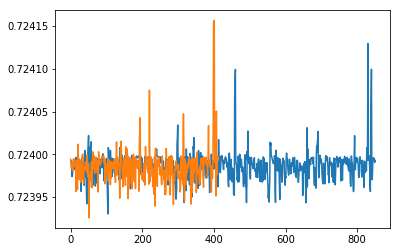

In [63]:
plt.plot(Y_positives)
plt.plot(Y_negatives)
plt.show()

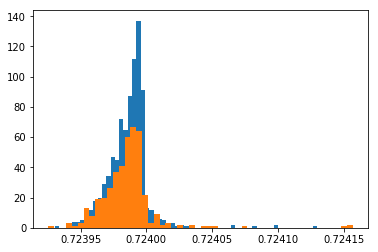

In [66]:
plt.hist(Y_positives, bins='auto')
plt.hist(Y_negatives, bins='auto')
plt.show()

In [67]:
from pyannote.metrics import binary_classification

ModuleNotFoundError: No module named 'pyannote'

In [34]:
import glob
import json
import re
import pickle
import pandas as pd
import spacy
import string
import numpy as np
import itertools
import csv
from joblib import Parallel, delayed
import torch
from torch.autograd import Variable
from random import shuffle
from random import sample
from models import InferSent
from sklearn.model_selection import train_test_split
import sys

import torchtext.vocab as vocab
nlp = spacy.load('en')

def load_data(config, path_transcripts='/vol/work2/galmant/transcripts/'):
    type_sentence_embedding = config['type_sentence_embedding']
    dev_set_list = config['dev_set_list']
    test_set_list = config['test_set_list']
    
    punctuations_end_sentence = ['.', '?', '!']
    punctuations = string.punctuation #['!','(',')',',','-','.','/',':',';','<','=','>','?','[','\\',']','^','_','{','|','}','~'] #!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

    we = None
    if type_sentence_embedding == 'lstm':
        we = vocab.FastText(language='en')

    X_train = []
    Y_train = []
    X_dev = []
    Y_dev = []
    X_test = []
    Y_test = []
    words_set = set()
    for file in sorted(glob.glob(path_transcripts+'*')):
        with open(file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            X_ = []
            Y_ = []
            for row in reader:
                #print(row)
                sentence = row[2]
                old_word = row[2]
                for word in row[3:]:
                    if any(punctuation in old_word for punctuation in punctuations_end_sentence) and word and word[0].isupper():
                        sentence = sentence.strip()
                        n = 0
                        for i,s in enumerate(sentence):
                            if s in punctuations:
                                sentence_ = list(sentence)
                                sentence_.insert(i + n + 1,' ')
                                sentence_.insert(i + n,' ')
                                sentence = ''.join(sentence_)
                                n += 2
                        #print(sentence)
                        X_.append(sentence)
                        Y_.append(row[1])
                        sentence = word
                    else:
                        sentence += ' '+word
                    old_word = word
                if sentence and row[1]:
                    sentence = sentence.strip()
                    n = 0
                    for i,s in enumerate(sentence):
                        if s in punctuations:
                            sentence_ = list(sentence)
                            sentence_.insert(i + n + 1,' ')
                            sentence_.insert(i + n,' ')
                            sentence = ''.join(sentence_)
                            n += 2
                    #print(sentence)
                    X_.append(sentence)
                    Y_.append(row[1])
            Y = [s.lower() for s in Y_]
            if type_sentence_embedding == 'lstm':
                X = [s.lower().split() for s in X_]
                #print(X)
                #Y = [s.lower() for s in Y_]
                to_del = []
                for s in X:
                    #print(s)
                    for w in s:
                        #print(w)
                        if w not in we.stoi:
                            to_del.append(w)
                            print('to del', w)
                X = [[w.strip() for w in s if w not in to_del] for s in X]
                for words_per_sentence in X:
                    words_set = words_set.union(set(words_per_sentence))
            else:
                X = X_
                Y = Y#_
            if len(X)>0 and len(Y)>0:
                names_episode = file.split('/')[-1]
                names_season = '.'.join(names_episode.split('.')[:-1])
                names_serie = '.'.join(names_episode.split('.')[0])
                if names_episode in dev_set_list or names_season in dev_set_list or names_serie in dev_set_list:
                    X_dev.append(X)
                    Y_dev.append(Y)
                elif names_episode in test_set_list or names_season in test_set_list or names_serie in test_set_list:
                    X_test.append(X)
                    Y_test.append(Y)
                else:
                    X_train.append(X)
                    Y_train.append(Y)
            assert len(X) == len(Y)
        #print(X)
        break
    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test, words_set, we

config = {}
config['dev_set_list']=['TheBigBangTheory.Season02']
config['test_set_list']=['TheBigBangTheory.Season01']
config['type_sentence_embedding']='lstm'#'infersent'
print('Load corpus dataset')
X_train, Y_train, X_dev, Y_dev, X_test, Y_test, words_set, we = load_data(config)

Load corpus dataset
to del t1
to del 212
to del koothrapali
to del 1974
to del 360


In [33]:
import datetime
x = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(' ','_')
print(x)

2019-07-17_05:40:44


In [41]:
a = ['BBT.S1', '*.S1']
for a_ in a:
    print(a_)
    if '*' in a_:
        print('True')
        break

BBT.S1
*.S1
True
